In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
val_folder = 'sample_test_sync'
S_PREFIX = '35-unet11-mini'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.87)
    yc[cutoff_y:,:] = 0
    return torch.from_numpy(np.stack((yc,yr)).astype(int))


def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [17]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [18]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, val_folder=None):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/pseudo/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if val_folder:
        x_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/{val_folder}/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [19]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.4914 , 0.48216, 0.44653])
    std=np.array([0.24703, 0.24349, 0.26159])
    x_np = x_np*std+mean
    return x_np

### Visualize data

In [20]:
sz = 96
bs = 2
ext = '-150'
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [21]:
x,y = md.val_ds[259]

In [ ]:
plt.imshow(y[1])

In [ ]:
y.shape

In [ ]:
plt.imshow(y[1])

In [ ]:
x_out = denorm(x)

In [ ]:
plt.imshow(x_out)

In [ ]:
plt.imshow(y)

## U-net (ish)

In [20]:
from torchvision.models import vgg11_bn

In [21]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [22]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [23]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [24]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [25]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [26]:
class Unet11Mini(nn.Module):
    def __init__(self, f=vgg11):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[0][i]) for i in [2,6,13,20,27]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,128)
        self.up4 = UnetBlock(128,64,64)
        self.up5  = nn.Conv2d(64,2,1)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [27]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [28]:
def car_f_p_r(pred, targs):
    p2 = F.sigmoid(pred)
    return fbeta_score(targs[:,0,:,:], p2[:,0,:,:], beta=2, threshold=0.5)

In [29]:
def rd_f(pred, targs):
#     mx,idx = torch.max(pred, 1)
    p2 = F.sigmoid(pred)
    f,p,r = fbeta_score(targs[:,1,:,:], p2[:,1,:,:], beta=0.5, threshold=0.5)
    return f

In [30]:
def fbeta_score(y_true, y_pred, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [31]:
def new_acc(pred, targs):
    p2 = F.sigmoid(pred)
    return ((p2>0.5).long() == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [32]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(weight.view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, targets):
        probs = F.sigmoid(logits)
        num = targets.size(0)  # Number of batches
        if isinstance(logits.data, torch.cuda.HalfTensor):
            targets = targets.half()
        else:
            targets = targets.float()
            
        if self.weight is not None:
            score = dice_coeff_weight(probs, targets, self.weight)
        else:
            score = dice_coeff(probs, targets)
        score = 1 - score.sum() / num
        return score

In [33]:
def get_learner(md, m_fn=Unet11Mini, half=False):
    m = to_gpu(m_fn())
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.cuda.FloatTensor([1,1/100])
    if half:
        class_weights = class_weights.half()
        learn.half()
#     learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss(weight=class_weights)
    learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

### Settings

In [36]:
ext = '-150'
sz = 96
bs = 128
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [37]:
# learn.load('600urn-19-weights-26-r8')

In [38]:
# learn.half()

In [39]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [40]:
lr=1e-1
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [41]:
learn.fit(lr,1,wds=wd,cycle_len=30,use_clr_beta=(20,10,0.95,0.85))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.996759   0.995025   0.647973   0.350073   0.453316   0.786815   0.410448  
    1      0.994921   0.993687   0.840066   0.546821   0.617403   0.656586   0.610023  
    2      0.994256   0.994448   0.954934   0.854406   0.371471   0.883301   0.325436  
    3      0.994039   0.994072   0.943077   0.894095   0.612431   0.570345   0.62602   
    4      0.994172   0.999504   0.663777   0.424608   0.104931   0.02508    0.517672  
    5      0.994426   0.995409   0.859524   0.581135   0.263968   0.834292   0.225977  
    6      0.994362   0.995736   0.913156   0.718747   0.219324   0.850287   0.185187  
    7      0.994383   0.995148   0.891173   0.658841   0.497973   0.442155   0.516546  
    8      0.994431   0.996195   0.85055    0.184325   0.341273   0.800316   0.298821  
    9      0.994857   0.99926    0.808971   0.549213   0.128424   0.038685   0.307088  
    10     0.994846   0.995251   0.905963   0.721421 

[array([0.99251]),
 0.9728604555130005,
 0.9297416565492227,
 0.6876303456183936,
 0.7642245555909029,
 0.6721984823842183]

In [42]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [43]:
learn.unfreeze()
learn.bn_freeze(True)

In [44]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [45]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993475   0.992373   0.974126   0.938267   0.750823   0.697179   0.767061  
    1      0.993417   0.992237   0.976353   0.937064   0.703109   0.798491   0.683848  
    2      0.993342   0.992139   0.978382   0.943292   0.756537   0.74489    0.760557  
    3      0.993293   0.992071   0.979132   0.955138   0.733503   0.791368   0.721542  
    4      0.993236   0.992103   0.979161   0.960303   0.722564   0.821903   0.702251  
    5      0.993219   0.991982   0.980699   0.956346   0.752207   0.78927    0.744491  
    6      0.993186   0.992049   0.979876   0.961181   0.72968    0.811603   0.712659  
    7      0.993168   0.991979   0.981284   0.959829   0.744031   0.803512   0.731553  
    8      0.993137   0.991962   0.980859   0.963567   0.753948   0.799278   0.744298  
    9      0.993135   0.99196    0.981573   0.963055   0.750212   0.803499   0.738886  



[array([0.99196]),
 0.9815726709365845,
 0.9630548008607674,
 0.75021204377672,
 0.8034988502108689,
 0.7388859718599439]

In [46]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993118   0.991944   0.981805   0.963116   0.753012   0.807679   0.741301  
    1      0.993118   0.991977   0.982427   0.957685   0.753963   0.787545   0.747263  
    2      0.993133   0.991958   0.982098   0.964622   0.750853   0.809869   0.738756  
    3      0.993104   0.991925   0.982551   0.96461    0.753838   0.810462   0.742162  
    4      0.993092   0.991885   0.983119   0.967557   0.765353   0.797851   0.758944  
    5      0.993085   0.991878   0.983755   0.968945   0.751179   0.823049   0.736352  
    6      0.993062   0.991876   0.984053   0.967691   0.764127   0.806651   0.755465  
    7      0.993051   0.991885   0.98375    0.969051   0.750849   0.822271   0.736186  
    8      0.993051   0.991852   0.98396    0.968492   0.760219   0.817929   0.74847   
    9      0.99304    0.991862   0.983877   0.969416   0.759045   0.816889   0.747259  



[array([0.99186]),
 0.9838771200180054,
 0.9694157419332641,
 0.7590445018647917,
 0.8168891077330598,
 0.7472589670374241]

In [47]:
learn.save(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:10])))

In [ ]:
# py = np.argmax(py,1)

In [ ]:
show_img(denorm(x[0]))

In [ ]:
py.shape

In [ ]:
show_img(py[0][0]>0.5);

In [ ]:
show_img(py[0][1]>0.5);

In [ ]:
show_img(y[0][1]);

## 256x256

In [61]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [62]:
lr=2e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [63]:
import gc
gc.collect()

1210

In [64]:
learn = get_learner(md)

In [65]:
learn.load(f'128urn-{S_PREFIX}-0')

In [66]:
learn.freeze_to(1)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [40]:
learn.load(f'128urn-{S_PREFIX}-0')

In [67]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.986165   0.985577   0.973844   0.92789    0.77546    0.847274   0.760773  
    1      0.986153   0.993538   0.913248   0.809366   0.514932   0.219794   0.782504  
    2      0.986303   0.986336   0.962543   0.883441   0.71998    0.823276   0.699789  
    3      0.986171   0.985877   0.970975   0.934699   0.730035   0.876921   0.702161  
    4      0.986061   0.986181   0.973172   0.92454    0.682984   0.919042   0.643041  
    5      0.985995   0.985404   0.975473   0.937444   0.780642   0.862012   0.76353   
    6      0.985993   0.985585   0.96503    0.879031   0.788765   0.832916   0.77955   
    7      0.986029   0.985414   0.974874   0.92937    0.790363   0.842405   0.77942   
    8      0.985926   0.985261   0.977729   0.942075   0.79725    0.853608   0.785108  
    9      0.98585    0.985318   0.975628   0.92517    0.77901    0.882653   0.757458  


[array([0.98532]),
 0.9756278109550476,
 0.925169533052979,
 0.7790104653909516,
 0.8826530729975101,
 0.7574581235071548]

In [68]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [69]:
learn.unfreeze()
learn.bn_freeze(True)

In [70]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.985778   0.985274   0.977472   0.936047   0.829946   0.796558   0.839636  
    1      0.985713   0.984966   0.983211   0.956232   0.820652   0.864249   0.81086   
    2      0.985652   0.985098   0.983333   0.96991    0.787867   0.901326   0.764351  
    3      0.98561    0.984859   0.985063   0.968274   0.822605   0.879633   0.809932  
    4      0.985568   0.984853   0.985615   0.970305   0.818628   0.887347   0.803506  
    5      0.985563   0.984783   0.986511   0.974091   0.829038   0.879238   0.81777   
    6      0.985514   0.984734   0.987126   0.971923   0.832769   0.882349   0.821627  
    7      0.985507   0.984734   0.987177   0.974507   0.83204    0.88375    0.820428  


[array([0.98473]),
 0.9871765112876892,
 0.9745068303382242,
 0.8320398820257786,
 0.8837499808542129,
 0.8204283277125102]

In [71]:
learn.fit(lrs/8,1,wds=wd, cycle_len=8,use_clr=(20,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.985505   0.984771   0.986599   0.975487   0.830437   0.88335    0.818636  
    1      0.985496   0.984787   0.986253   0.974798   0.826042   0.8859     0.812748  
    2      0.985513   0.984722   0.987448   0.975538   0.835497   0.881052   0.825269  
    3      0.985506   0.984753   0.98738    0.976206   0.829562   0.883517   0.81759   
    4      0.985453   0.984719   0.987969   0.975431   0.826118   0.899293   0.810112  
    5      0.985445   0.984651   0.988038   0.976318   0.844563   0.875842   0.837584  
    6      0.985419   0.984631   0.988121   0.976998   0.840015   0.887894   0.829256  
    7      0.985425   0.984629   0.988214   0.977389   0.840478   0.888606   0.829711  


[array([0.98463]),
 0.9882141613960266,
 0.9773893461736209,
 0.8404782343994575,
 0.8886061011216124,
 0.8297106976888042]

In [72]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [73]:
x,y = next(iter(md.trn_dl))

In [ ]:
x.shape

In [80]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:8])))

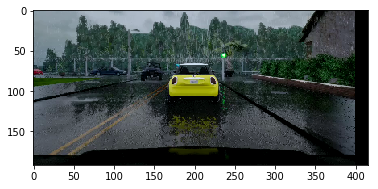

In [84]:
plt.imshow(denorm(x[0]))

In [81]:
py.shape

(8, 2, 192, 416)

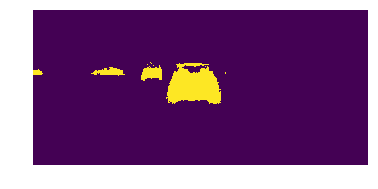

In [83]:
show_img(py[0][0]>0);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[-1]);

### No Crop

In [34]:
ext = '-300'
sz=192
bs=32
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [35]:
learn = get_learner(md)

In [36]:
learn.load(f'256urn-{S_PREFIX}')

In [37]:
learn.unfreeze()
learn.bn_freeze(True)

In [38]:
lr=1e-3
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [39]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.971319   0.972663   0.985133   0.981089   0.772457   0.880258   0.752653  
    1      0.970868   0.972422   0.988502   0.976083   0.820093   0.819677   0.822355  
    2      0.971159   0.971565   0.988506   0.979523   0.848799   0.853025   0.849239  
    3      0.970149   0.971073   0.991583   0.986535   0.836902   0.916382   0.820666  
    4      0.969899   0.970779   0.991789   0.987764   0.867764   0.895109   0.862512  
    5      0.969709   0.970682   0.992612   0.985717   0.867298   0.903328   0.859862  
    6      0.969642   0.970499   0.993375   0.988657   0.880333   0.89987    0.876564  
    7      0.969601   0.970536   0.993419   0.988986   0.87951    0.897384   0.876179  
    8      0.969508   0.970447   0.993878   0.989567   0.87347    0.916358   0.864305  
    9      0.969441   0.970364   0.994169   0.989627   0.884516   0.905385   0.880349  



[array([0.97036]),
 0.994169294834137,
 0.9896270863431684,
 0.8845162915416096,
 0.9053849313868426,
 0.880349149779845]

In [40]:
learn.save(f'256urn-{S_PREFIX}-nocrop')

## 512x512

In [34]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.968783   0.995293   0.68591    0.522779   0.116322   0.030925   0.455649  



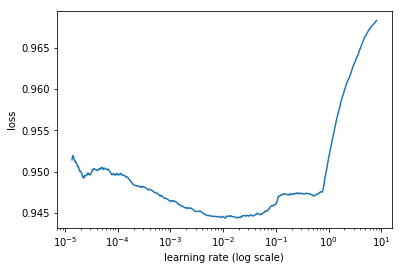

In [36]:
learn.lr_find()
learn.sched.plot()

In [37]:
# learn.load(f'256urn-{S_PREFIX}')
learn.load(f'256urn-{S_PREFIX}-nocrop')

In [38]:
learn.freeze_to(1)

In [39]:
lr=1e-3
wd=5e-7

In [40]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(10,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.942989   0.945336   0.985199   0.961679   0.824425   0.8961     0.810865  
    1      0.941987   0.945431   0.986235   0.966544   0.807719   0.914777   0.787693  
    2      0.9417     0.944969   0.986622   0.971307   0.82353    0.909224   0.807251  
    3      0.941502   0.944935   0.987344   0.969363   0.817855   0.918573   0.798501  



[array([0.94494]),
 0.9873442149162293,
 0.9693631207351949,
 0.8178552081360246,
 0.9185728282049055,
 0.7985014764819514]

In [ ]:
learn.fit(lr/4,1, wds=wd, cycle_len=4,use_clr=(10,4))

In [41]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [42]:
learn.unfreeze()
learn.bn_freeze(True)

In [43]:
lrs = np.array([lr/200,lr/20,lr])/2

In [44]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.941458   0.944726   0.987379   0.969695   0.828688   0.909876   0.81306   
    1      0.941493   0.944751   0.987467   0.969821   0.826349   0.912596   0.809743  
    2      0.94133    0.944718   0.987471   0.970933   0.828113   0.911154   0.812098  
    3      0.941114   0.944686   0.987512   0.970636   0.828169   0.912439   0.811867  



[array([0.94469]),
 0.987511761188507,
 0.9706357799994356,
 0.8281685036388582,
 0.9124385126176295,
 0.8118672330161044]

In [ ]:
learn.fit(lrs/40,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [45]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
learn.sched.plot_loss()

### No Crop

In [34]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=12
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, val_folder)

learn = get_learner(md)

Val Labels: 400
Val x:400, y:400
Trn x:7280, y:7280
All x:7280


In [36]:
# learn.load(f'600urn-{S_PREFIX}')
learn.load(f'256urn-{S_PREFIX}-nocrop')

In [35]:
lr=2e-3
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
learn.fit(lrs,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.921264   0.924071   0.98828    0.970293   0.839325   0.858655   0.839872  
    1      0.920456   0.923644   0.989334   0.97367    0.835536   0.887359   0.830307  
    2      0.91956    0.923169   0.989862   0.979082   0.839673   0.899166   0.832119  
    3      0.919087   0.922866   0.990632   0.979834   0.845588   0.898936   0.839085  



[array([0.92287]),
 0.9906322306394577,
 0.9798339830359591,
 0.8455876315442036,
 0.8989360754791494,
 0.8390854106432449]

In [40]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp')

In [36]:
learn.load(f'600urn-{S_PREFIX}-nocrop-tmp')

In [37]:
learn.unfreeze()
learn.bn_freeze(True)

In [38]:
learn.fit(lrs/6,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.91941    0.922863   0.990688   0.97942    0.847109   0.893718   0.841771  
    1      0.919294   0.922827   0.990863   0.978566   0.846165   0.897326   0.839702  
    2      0.91939    0.922718   0.991042   0.979854   0.844776   0.901347   0.836939  
    3      0.919282   0.922729   0.990989   0.980401   0.845334   0.901075   0.837903  



[array([0.92273]),
 0.9909885984659195,
 0.9804010773724668,
 0.8453337806682795,
 0.9010747842806437,
 0.8379029030335137]

In [39]:
learn.save(f'600urn-{S_PREFIX}-nocrop-tmp-2')

In [40]:
learn.fit(lrs/50,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.919283   0.922718   0.991064   0.980019   0.844192   0.903302   0.836038  
    1      0.919213   0.922711   0.991079   0.979829   0.846855   0.898623   0.840174  
    2      0.919148   0.92272    0.99098    0.980573   0.843912   0.904664   0.835471  
    3      0.919214   0.922712   0.991015   0.980364   0.845317   0.902067   0.837657  



[array([0.92271]),
 0.9910149848461152,
 0.9803636208753217,
 0.8453172678413479,
 0.9020671070379211,
 0.8376572297962268]

In [41]:
learn.save(f'600urn-{S_PREFIX}-nocrop')

### Visualize Results

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(F.sigmoid(learn.model(V(x[:10]))))

In [ ]:
# py = np.argmax(py,1)

In [ ]:
idx=4

In [ ]:
plt.imshow(denorm(x[idx]))

In [ ]:
show_img(py[idx][0]>0.5);

In [ ]:
show_img(py[idx][1]>0.5);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[idx][0]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()